In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import skimage.feature as skf
from skimage import segmentation, color
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
def graph_based_segmentation(image):
    # Apply graph-based segmentation
    segments = segmentation.slic(image, compactness=30, n_segments=400)
    segmented_image = color.label2rgb(segments, image, kind='avg')
    return segmented_image, segments

In [5]:
def extract_crack_features(image, segments):
    features = []
    for segment_label in np.unique(segments):
        mask = segments == segment_label
        segment_image = image * mask[:, :, np.newaxis]
        gray_segment = cv2.cvtColor(segment_image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
        
        # Calculate GLCM features
        glcm = skf.graycomatrix(gray_segment, distances=[1], angles=[0], symmetric=True, normed=True)
        contrast = skf.graycoprops(glcm, 'contrast')
        dissimilarity = skf.graycoprops(glcm, 'dissimilarity')
        homogeneity = skf.graycoprops(glcm, 'homogeneity')
        energy = skf.graycoprops(glcm, 'energy')
        correlation = skf.graycoprops(glcm, 'correlation')
        
        # Calculate edge count using Canny edge detection
        edges = cv2.Canny(gray_segment, threshold1=50, threshold2=150)  # Adjust thresholds for crack detection
        edge_count = np.sum(edges > 0)  # Count the number of edge pixels
        
        # Calculate edge density (edges per pixel)
        edge_density = edge_count / (gray_segment.shape[0] * gray_segment.shape[1])
        
        # Append features
        features.append([
            contrast[0, 0], dissimilarity[0, 0], homogeneity[0, 0], energy[0, 0], correlation[0, 0],
            edge_count,edge_density
        ])
    
    return np.array(features)

In [10]:
from tqdm import tqdm  # Import tqdm for progress bar

def create_dataset(image_folder, max_images_per_category=5000):
    X = []
    y = []
    
    # Iterate through Positive and Negative folders
    for label, folder_name in enumerate(['Positive', 'Negative']):
        folder_path = os.path.join(image_folder, folder_name)
        image_files = os.listdir(folder_path)
        
        # Counter to track the number of images processed for this category
        image_count = 0
        
        # Use tqdm to show progress for each folder
        for image_name in tqdm(image_files, desc=f"Processing {folder_name}", unit="image"):
            # Stop if the limit for this category is reached
            if image_count >= max_images_per_category:
                print(f"Reached the limit of {max_images_per_category} images for {folder_name}. Moving to the next category.")
                break
            
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read image {image_path}. Skipping.")
                continue
            
            # Apply graph-based segmentation
            segmented_image, segments = graph_based_segmentation(image)
            
            # Extract GLCM features
            features = extract_crack_features(segmented_image, segments)
            
            # Average features across segments
            if len(features) > 0:
                avg_features = np.mean(features, axis=0)
                X.append(avg_features)
                y.append(label)
                image_count += 1  # Increment the counter
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [11]:
def save_dataset_as_csv(X, y, output_file):
    # Create a DataFrame
    feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation','edge count','edge density']
    df = pd.DataFrame(X, columns=feature_names)
    df['label'] = y
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Dataset saved to {output_file}")

In [13]:
image_folder = r"C:\Users\EDWIN\OneDrive\Desktop\Study materials\SEM-6\MV Project\Dataset"
    
# Create dataset
X, y = create_dataset(image_folder)
    
# Save dataset as CSV
save_dataset_as_csv(X, y, 'extracted_features.csv')

Processing Positive:   0%|          | 0/20000 [00:00<?, ?image/s]

Processing Positive:  25%|██▌       | 5000/20000 [2:04:36<6:13:50,  1.50s/image]


Reached the limit of 5000 images for Positive. Moving to the next category.


Processing Negative:  25%|██▌       | 5000/20000 [1:59:33<5:58:39,  1.43s/image] 

Reached the limit of 5000 images for Negative. Moving to the next category.
Dataset saved to extracted_features.csv


In [14]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [15]:
    # Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    
    # Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
    
    # Build and train the model
model = build_model((X_train.shape[1],), y_train.shape[1])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50


C:\Users\EDWIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8018 - loss: 0.4441 - val_accuracy: 0.9335 - val_loss: 0.1753
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9216 - loss: 0.2184 - val_accuracy: 0.9445 - val_loss: 0.1541
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9316 - loss: 0.1806 - val_accuracy: 0.9470 - val_loss: 0.1477
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9297 - loss: 0.1968 - val_accuracy: 0.9470 - val_loss: 0.1443
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9289 - loss: 0.1712 - val_accuracy: 0.9490 - val_loss: 0.1392
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9381 - loss: 0.1667 - val_accuracy: 0.9445 - val_loss: 0.1412
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9379 - loss: 0.1655 - val_accuracy: 0.9470 - val_loss: 0.1337
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9390 - loss: 0.1541 - val_accuracy: 0.9470 - val_

In [16]:
model.save('trained_model.h5')

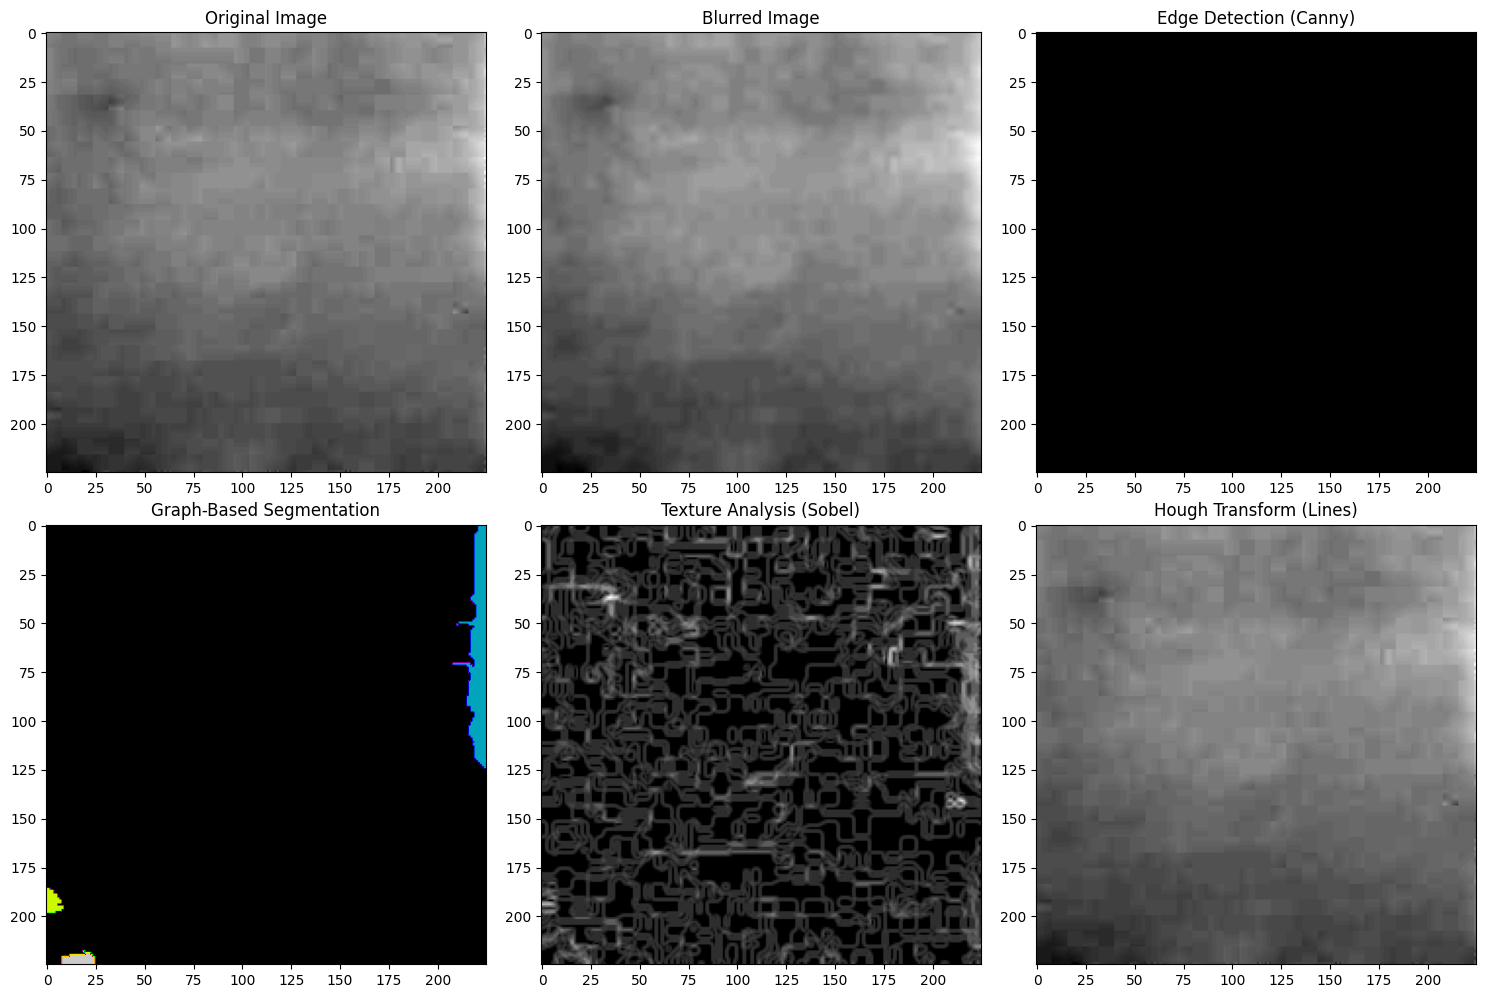

In [12]:
import cv2
import numpy as np
from skimage import filters, segmentation, feature
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt

# Step 1: Load the image
image_path = 'nocrack.jpg'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Step 2: Preprocessing - Image Enhancement
# Apply Gaussian blur for noise reduction
image_blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Step 3: Edge Detection using Canny
edges = cv2.Canny(image_blurred, threshold1=50, threshold2=150)

# Step 4: Graph-Based Segmentation (using Felzenszwalb's algorithm)
segments = segmentation.felzenszwalb(image_blurred, scale=150, sigma=0.75, min_size=75)

# Step 5: Texture Analysis using Sobel filter
texture_edges = sobel(image_blurred)

# Step 6: Hough Transform for Line Detection
h, theta, d = hough_line(edges)
accumulator, angles, dists = hough_line_peaks(h, theta, d)

# Step 7: Display Results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ax = axes.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(image_blurred, cmap='gray')
ax[1].set_title('Blurred Image')

ax[2].imshow(edges, cmap='gray')
ax[2].set_title('Edge Detection (Canny)')

ax[3].imshow(segments, cmap='nipy_spectral')
ax[3].set_title('Graph-Based Segmentation')

ax[4].imshow(texture_edges, cmap='gray')
ax[4].set_title('Texture Analysis (Sobel)')

ax[5].imshow(image, cmap='gray')
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[5].plot((0, image.shape[1]), (y0, y1), '-r')
ax[5].set_title('Hough Transform (Lines)')

plt.tight_layout()
plt.show()

In [7]:
import cv2
import numpy as np
from skimage import filters, segmentation
from skimage.filters import sobel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Step 1: Feature Extraction
def extract_features(image):
    # Preprocess the image
    image_blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Edge detection
    edges = cv2.Canny(image_blurred, threshold1=50, threshold2=150)
    
    # Texture analysis
    texture_edges = sobel(image_blurred)
    
    # Graph-based segmentation
    segments = segmentation.felzenszwalb(image_blurred, scale=100, sigma=0.5, min_size=50)
    
    # Extract features
    edge_feature = np.mean(edges)  # Mean edge intensity
    texture_feature = np.mean(texture_edges)  # Mean texture intensity
    mean_intensity = np.mean(image_blurred)  # Mean intensity of the image
    std_intensity = np.std(image_blurred)  # Standard deviation of intensity
    
    return [edge_feature, texture_feature, mean_intensity, std_intensity]

In [10]:
# Step 1: Load the image
image_path = '00040.jpg'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(extract_features(image))

# Step 1: Load the image
image_path = '00042.jpg'  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(extract_features(image))

[1.4895495740262765, 0.012522809900338753, 206.68208193444468, 10.031667789448365]
[4.052960468862194, 0.014922025734173894, 161.6572803663956, 21.597510846105124]
